In [13]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = '/githome/me/Documents/BWA/data/bw_portfolios'

#Open binance client
client = Client(api_key, secret_key)

#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))


def get_data(sym,prev_k,k,candle_k='5m'):
    """
    Function downloads hist data from binance API with given timestamps
    """
    #previous kline interval
    prev_k = str(prev_k)
    #current kline interval
    k = str(k)
    #download historical data
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def normalize(data,column="Close",deci = False):
    """
    Function for simple time series normalization 
    """
    if(deci==True):
        norm_close =  data[column].divide(data[column].iloc[0])-1
    else:
        norm_close =  data[column].divide(data[column].iloc[0])
        
    return norm_close


def to_dt(v,is_milli=True):
    """
    Function to convert timestamp to datetime object
    has parameter for millisecond uts timestamp
    """
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    """
    Function loads all signal csv files and concatenates them into a signle dataframe
    """
    # cd cmd
    os.chdir(bw_location)
    #sorting by file creation (could use normal sort as filenames are timestamps)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    #Create frequency signal dataframe
    fs_df = pd.DataFrame(files)
    #sort again
    fs_df = fs_df[0].sort_values()
    #starttime,endtime
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    """
    Function to clean frequency signal dataframe
    """
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    """
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
    """    
    return fs
def make_all_coins(cgroups):
    all_coins = pd.DataFrame()
    for sym in coins:
        coin = cgroups.get_group(sym)

        #the secret sauce, extracting value from our data
        #for this example im using the time difference between the signal event occurence to determine enter/exits
        t_dif = []
        for i in range(0,len(coin)-1):
            t1 = coin['Date_m'].iloc[i]
            t2 = coin['Date_m'].iloc[i+1]
            td = (t2-t1)
            #if(td) signal logic
            t_dif.append(td)
        t_dif.append(0)
        #print(t_dif==coin['t_diff'])
        coin = coin.assign(t_dif = t_dif)
        coin.t_dif = coin.t_dif.shift(1)

        coin = coin.fillna(method='bfill')
        coin.t_dif = coin.t_dif.pct_change()
        coin = coin[['Close','t_dif','Date_m']].copy()
        coin.Close = normalize(coin)
        coin.fillna(method='bfill')

        #make copy w/ no index for resample and hist data sync
        #create daily signals from intraday signal dataset
        dc = coin.reset_index().copy()
        dc.index = dc.Date
        #Daily resample
        daily_coin = dc.resample('D').sum()

        #daily resampled date index
        dates = list(daily_coin.index)
        print(sym)
        print(dates[0].strftime('%Y-%m-%d'),"   |   ",dates[-1].strftime('%Y-%m-%d'))
        prev_k,k = int(dates[0].timestamp()*1000), int(dates[-1].timestamp()*1000)

        #Download historical data
        c_hist = get_data(sym,prev_k,k,candle_k='1d')
        c_hist['Entry'] = to_dt(coin.Date_m.iloc[-1])
        #extract signal for resampled signal dataframe and create signal column (-1,1) ...maybe (-1,0,1)
        c_hist['Close_diff'] = c_hist['Close'].diff().apply(np.sign)

        # log of 5 day moving average of volume

        c_hist['5dlv'] = c_hist.Volume.rolling(5).mean().apply(np.log) 

        # daily volume vs. 200 day moving average

        c_hist['v_3v'] = c_hist.Volume/ c_hist.Volume.rolling(3).mean()-1
        c_hist['vpct'] =  c_hist.Volume.pct_change()
        c_hist['3vpct'] = c_hist['vpct'].rolling(3).sum()


        c_hist['bw_sig'] = daily_coin.t_dif
        c_hist['sig3'] = c_hist["bw_sig"].apply(np.sign)
        c_hist['sig3'] = c_hist['sig3'].replace(0,-1)
        c_hist = c_hist.fillna(0) 
        c_hist["daily_returns"] = (c_hist['Close']/c_hist['Open'])-1
        """
        #Visualize trading range and signal
        c_hist2 = c_hist[["Close","sig3"]].copy()
        c_hist2.Close = normalize(c_hist2,deci=True)
        c_hist2["High"] = normalize(c_hist,column="High",deci=True)
        c_hist2["Low"] = normalize(c_hist,column="Low",deci=True)
        c_hist2.plot(figsize=(8,5))
        #plt.savefig("/home/me/Pictures/{}range_signal.png".formate(sym))

        c_hist[['sig3','Close_diff']].plot(grid=True,figsize=(8,5))
        """


        c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
        c_hist['Strategy Returns'] = c_hist['Market Returns'] * c_hist['sig3'].shift(1)
        c_hist['Coin'] = sym
        c_hist = c_hist.reset_index()
        c_hist = c_hist.set_index(['Open time','Coin'])

        all_coins = pd.concat([all_coins,c_hist])

    #dts is dates for resampled df
    dts = all_coins.index.get_level_values(0)

    fol = dts[0].strftime('%Y-%m-%d')+"_"+dts[-1].strftime('%Y-%m-%d')
    print(fol)
    #save all_coin to csv
    fname = '/home/me/Documents/BWA/data/'
    if os.path.exists(fname) == False:
        os.mkdir(fname)
        all_coins.to_csv(fname+"all_coin.csv")
    return all_coins

def unix_time_millis(dt):
    """
    Function to convert unix time to millesecond
    """
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    """
    Function to resample frequency dataframe to specified frequency
    
    """
    intv_list = []
    out = pd.DataFrame()
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        intv_list.append(p)
        data = fs_c.loc[p:n]
        #print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        
    return out.sort_index(),intv_list
    #files.sort(key=lambda x: os.path.getmtime(x))


In [14]:
#get freq. signal df
freq_loc = '/home/me/Documents/BWA/data/freq_concat.csv'
fs = pd.read_csv(freq_loc)
#clean freq. signal df
fs_c = clean_fs(fs)
#multilevel indexing for interval tracking
fs_c = fs_c.set_index(['Date','Coin'])
#print(fs_c.head(3))
#print(fs_c.tail(3))
#Create start and end for interval dataframe 
st,end = fs_c.index[0][0],fs_c.index[-1][0]
st,end = unix_time_millis(st),unix_time_millis(end)

#30d interval for portfolio generation
intv = 30
#make multiindex frequency dataframe 
#works on fs_c
freq_df,intv_list = interval(intv,st,end)
#group by Coin
cgroups = freq_df.groupby('Coin')
#make list of all syms/dates in dataframe.... the index
coins = list(freq_df.index.get_level_values('Coin').drop_duplicates())
dates = list(freq_df.index.get_level_values('Date').drop_duplicates())


#test print of grouped dataframe
coin = cgroups.get_group(coins[0])
fname = '/home/me/Documents/BWA/data/'
update = input("update all_coins?")
if update == 'y':
    all_coins = make_all_coins(cgroups)
else:
    all_coins = pd.read_csv(fname+'all_coins.csv')

                              Unnamed: 0     Close    Profit      Loss  \
Date                Coin                                                 
2018-08-24 04:09:22 ENGBTC             0  0.000099  0.000101  0.000097   
                    DASHBTC            1  0.021344  0.021771  0.020917   
2018-08-24 04:15:06 THETABTC           2  0.000015  0.000016  0.000015   

                                     Date_m  
Date                Coin                     
2018-08-24 04:09:22 ENGBTC    1535083762289  
                    DASHBTC   1535083762289  
2018-08-24 04:15:06 THETABTC  1535084106238  
                              Unnamed: 0     Close    Profit      Loss  \
Date                Coin                                                 
2019-01-21 14:36:08 GRSBTC         93083  0.000059  0.000060  0.000058   
2019-01-21 14:42:08 WAVESBTC       93084  0.000707  0.000721  0.000693   
                    APPCBTC        93085  0.000013  0.000014  0.000013   

                            

## Daily resampling for signal/event generation

### creates a dataframe for all coins w/ signals for trading/backtesting
Makes a single csv w/ all coins and multilevel indexing by portfolio time
https://alphascientist.com/feature_engineering.html

c_hist is feature df

update all_coins?y
DASHBTC
2018-08-24    |    2019-01-20
ENGBTC
2018-08-24    |    2019-01-21
THETABTC
2018-08-24    |    2019-01-21
APPCBTC
2018-08-24    |    2019-01-21
GVTBTC
2018-08-24    |    2019-01-20
OAXBTC
2018-08-24    |    2019-01-21
AIONBTC
2018-08-24    |    2019-01-07
HCBTC
2018-08-24    |    2019-01-21
WINGSBTC
2018-08-24    |    2019-01-21
POLYBTC
2018-08-24    |    2019-01-21
ARDRBTC
2018-08-24    |    2019-01-19
ZENBTC
2018-08-24    |    2019-01-21
CMTBTC
2018-08-24    |    2019-01-21
IOTABTC
2018-08-24    |    2019-01-21
NEBLBTC
2018-08-24    |    2019-01-21
ETHBTC
2018-08-24    |    2019-01-20
ICXBTC
2018-08-24    |    2019-01-20
LOOMBTC
2018-08-24    |    2019-01-21
NANOBTC
2018-08-24    |    2019-01-21
REPBTC
2018-08-24    |    2019-01-21
MODBTC
2018-08-24    |    2019-01-21
LSKBTC
2018-08-24    |    2019-01-20
BNBBTC
2018-08-24    |    2019-01-20
VIBEBTC
2018-08-24    |    2019-01-21
ELFBTC
2018-08-24    |    2019-01-20
MANABTC
2018-08-24    |    2019-01-16
WAVES

# Generate portfolios

In [16]:
all_coins

,,Open,High,Low,Close,Close time,Volume,Entry,Close_diff,5dlv,v_3v,vpct,3vpct,bw_sig,sig3,daily_returns,Market Returns,Strategy Returns
Open time,Coin,,,,,,,,,,,,,,,,,
2018-08-24,DASHBTC,0.021539,0.022011,0.021108,0.021704,1.535155e+12,19175.437,2019-01-20 18:01:39.292,0.0,0.000000,0.000000,0.000000,0.000000,100.705387,1.0,0.007661,NaN,NaN
2018-08-25,DASHBTC,0.021702,0.021817,0.021200,0.021499,1.535242e+12,14982.994,2019-01-20 18:01:39.292,-1.0,0.000000,0.000000,-0.218636,0.000000,174.461872,1.0,-0.009354,-0.009490,-0.009490
2018-08-26,DASHBTC,0.021477,0.021530,0.020856,0.021102,1.535328e+12,21558.201,2019-01-20 18:01:39.292,-1.0,0.000000,0.160777,0.438845,0.000000,94.187298,1.0,-0.017461,-0.018639,-0.018639
2018-08-27,DASHBTC,0.021089,0.027886,0.021013,0.026598,1.535414e+12,39287.874,2019-01-20 18:01:39.292,1.0,0.000000,0.554333,0.822410,1.042618,97.220673,1.0,0.261226,0.231468,0.231468
2018-08-28,DASHBTC,0.026593,0.028475,0.024780,0.027409,1.535501e+12,38847.435,2019-01-20 18:01:39.292,1.0,10.195052,0.169006,-0.011211,1.250044,120.439360,1.0,0.030685,0.030035,0.030035
2018-08-29,DASHBTC,0.027362,0.028828,0.026361,0.026581,1.535587e+12,27475.719,2019-01-20 18:01:39.292,-1.0,10.255216,-0.219521,-0.292728,0.518472,0.000000,-1.0,-0.028543,-0.030675,-0.030675
2018-08-30,DASHBTC,0.026582,0.026841,0.025465,0.026515,1.535674e+12,17455.668,2019-01-20 18:01:39.292,-1.0,10.272461,-0.374937,-0.364687,-0.668626,0.000000,-1.0,-0.002521,-0.002486,0.002486
2018-08-31,DASHBTC,0.026465,0.027878,0.026291,0.027698,1.535760e+12,18709.313,2019-01-20 18:01:39.292,1.0,10.252566,-0.118050,0.071819,-0.585596,0.000000,-1.0,0.046590,0.043650,-0.043650
2018-09-01,DASHBTC,0.027699,0.031530,0.027638,0.030890,1.535846e+12,34774.333,2019-01-20 18:01:39.292,1.0,10.220212,0.470595,0.858664,0.565796,0.000000,-1.0,0.115203,0.109072,-0.109072


In [17]:
last_n_hist = pd.DataFrame()
portfolio = pd.DataFrame()
dates = all_coins.index.get_level_values('Open time').drop_duplicates()
coins = all_coins.index.get_level_values('Coin')
last_dates = dates[-5:]
for day in dates[-5:]:
    curr = all_coins.loc[day].sort_values(['bw_sig','vpct'],ascending=[False,False]).iloc[:10].copy()
    curr = curr[['Open','Close','bw_sig','sig3','Entry']].copy()
    curr['Date'] = day
    portfolio = pd.concat([portfolio,curr])
    

    #curr

    #print("\n",day,"\n",pt)
    #print(curr)
    
#all_coins.sort_values(["Open time","v_3v"]).iloc[-10:]
portfolio = portfolio.reset_index()
portfolio.set_index(['Date','Coin'])

Open     Close        bw_sig  sig3  \
Date       Coin                                               
2019-01-17 DOCKBTC   0.000003  0.000003  10352.470951   1.0   
           MTLBTC    0.000066  0.000065   1738.459728   1.0   
           GXSBTC    0.000146  0.000154   1700.082830   1.0   
           VIABTC    0.000083  0.000084   1506.548752   1.0   
           REQBTC    0.000006  0.000006   1118.935283   1.0   
           EOSBTC    0.000669  0.000685    518.807114   1.0   
           XRPBTC    0.000091  0.000090    517.718062   1.0   
           NXSBTC    0.000095  0.000096    375.685085   1.0   
           EDOBTC    0.000226  0.000228    293.986607   1.0   
           CVCBTC    0.000014  0.000015    293.710757   1.0   
2019-01-18 STEEMBTC  0.000094  0.000107   3023.244830   1.0   
           XLMBTC    0.000030  0.000029    704.976424   1.0   
           WINGSBTC  0.000021  0.000021    502.437339   1.0   
           WAVESBTC  0.000712  0.000703    499.127625   1.0   
           LOOMBTC   0.000013  0.000012    492.434622   1.0   
           TUSDBTC   0.000275  0.000277    436.429289   1.0   
           MODBTC    0.000085  0.000090    365.477338   1.0   
           QLCBTC    0.000007  0.000007    348.632179   1.0   
           SUBBTC    0.000013  0.000013    343.032808   1.0   
           ARKBTC    0.000111  0.000114    337.299359   1.0   
2019-01-19 POABTC    0.000008  0.000009   1394.264178   1.0   
           ENJBTC    0.000009  0.000009    828.164218   1.0   
           ELFBTC    0.000030  0.000031    692.083472   1.0   
           EOSBTC    0.000676  0.000667    566.214277   1.0   
           OSTBTC    0.000006  0.000006    564.035155   1.0   
           KMDBTC    0.000181  0.000188    524.501933   1.0   
           NXSBTC    0.000093  0.000098    511.823780   1.0   
           STORJBTC  0.000037  0.000041    489.942606   1.0   
           CMTBTC    0.000007  0.000008    363.540734   1.0   
           NEBLBTC   0.000316  0.000321    230.352789   1.0   
2019-01-20 ZILBTC    0.000006  0.000006   1796.781839   1.0   
           ENGBTC    0.000078  0.000078    784.482329   1.0   
           ETHBTC    0.033441  0.033214    642.478092   1.0   
           SYSBTC    0.000012  0.000012    451.861047   1.0   
           PPTBTC    0.000368  0.000362    448.405752   1.0   
           LSKBTC    0.000345  0.000343    248.787299   1.0   
           POWRBTC   0.000032  0.000032    241.102924   1.0   
           REPBTC    0.004681  0.005073    223.161616   1.0   
           NEBLBTC   0.000322  0.000313    216.409302   1.0   
           ENJBTC    0.000009  0.000009    214.268443   1.0   
2019-01-21 ASTBTC    0.000008  0.000008    471.230108   1.0   
           BCPTBTC   0.000009  0.000009    353.021443   1.0   
           IOTABTC   0.000083  0.000085    339.718227   1.0   
           QSPBTC    0.000005  0.000005    236.875428   1.0   
           BNTBTC    0.000154  0.000152    212.621153   1.0   
           PPTBTC    0.000363  0.000363    201.796643   1.0   
           ENGBTC    0.000078  0.000078    185.071636   1.0   
           KMDBTC    0.000182  0.000184    183.152433   1.0   
           CVCBTC    0.000014  0.000015    166.079402   1.0   
           MODBTC    0.000087  0.000092    162.336310   1.0   

                                      Entry  
Date       Coin                              
2019-01-17 DOCKBTC  2019-01-17 16:48:13.365  
           MTLBTC   2019-01-20 16:11:01.544  
           GXSBTC   2019-01-19 22:32:35.253  
           VIABTC   2019-01-20 03:55:36.968  
           REQBTC   2019-01-17 09:46:18.810  
           EOSBTC   2019-01-19 18:57:56.547  
           XRPBTC   2019-01-20 20:03:40.428  
           NXSBTC   2019-01-20 16:16:48.662  
           EDOBTC   2019-01-20 06:11:28.378  
           CVCBTC   2019-01-21 00:59:01.170  
2019-01-18 STEEMBTC 2019-01-18 11:08:14.080  
           XLMBTC   2019-01-18 16:21:13.865  
           WINGSBTC 2019-01-21 02:47:51.496  
           WAVESBTC 2019-01-21 09:42:08.306  
           L

In [33]:
today = portfolio.iloc[-10:].copy()
today.reset_index()
today = today.set_index("Coin")
today['Open'].astype(str)

Coin
ASTBTC       7.73e-06
BCPTBTC      9.25e-06
IOTABTC     8.345e-05
QSPBTC       4.68e-06
BNTBTC     0.00015396
PPTBTC      0.0003626
ENGBTC      7.834e-05
KMDBTC      0.0001824
CVCBTC      1.449e-05
MODBTC       8.71e-05
Name: Open, dtype: object

ASTBTC 2019-01-21 07:40:16.855000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


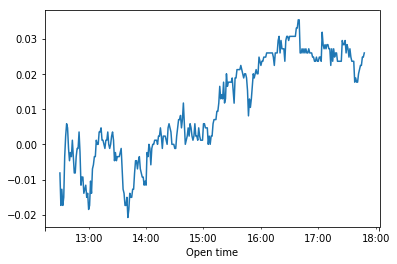

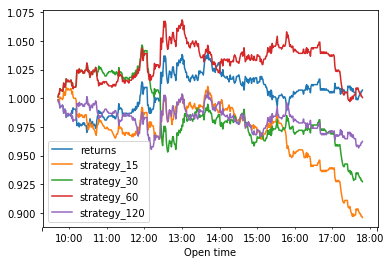

1548056416855 1548092906447
BCPTBTC 2019-01-21 05:35:52.171000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


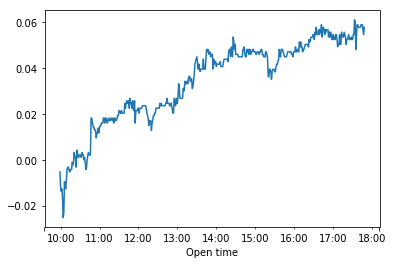

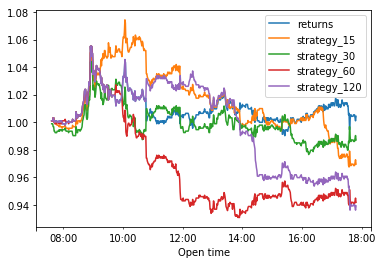

1548048952171 1548092906447
IOTABTC 2019-01-21 08:38:24.541000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


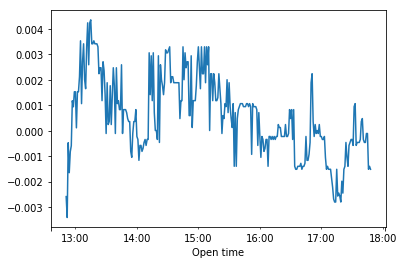

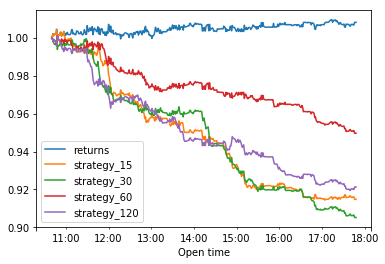

1548059904541 1548092906447
QSPBTC 2019-01-21 00:24:09.500000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


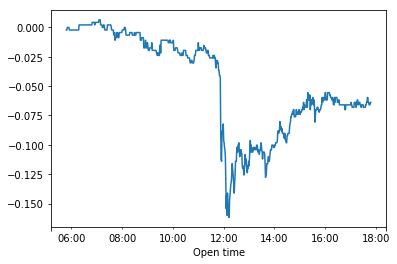

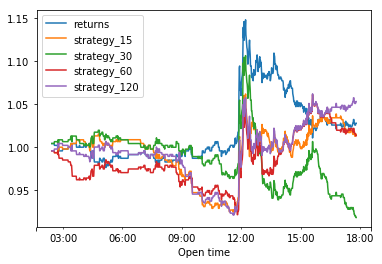

1548030249500 1548092906447
BNTBTC 2019-01-21 05:30:17.054000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


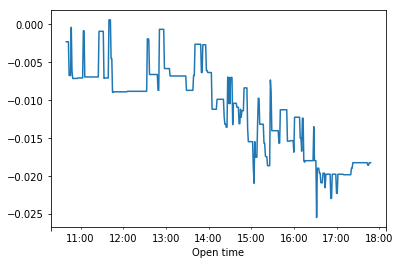

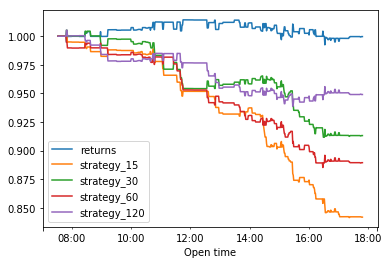

1548048617054 1548092906447
PPTBTC 2019-01-21 00:29:53.766000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


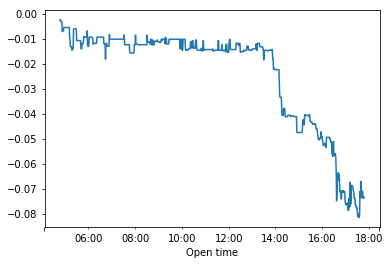

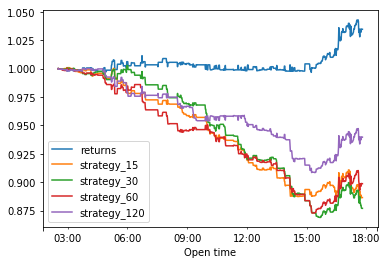

1548030593766 1548092906447
ENGBTC 2019-01-21 08:55:50.857000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


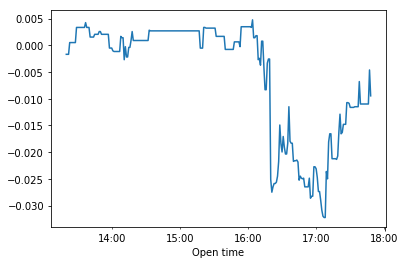

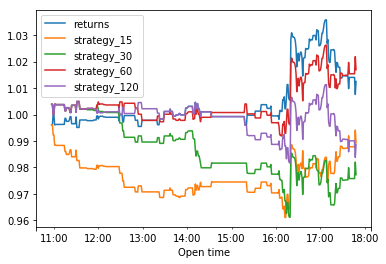

1548060950856 1548092906447
KMDBTC 2019-01-21 07:00:21.555000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


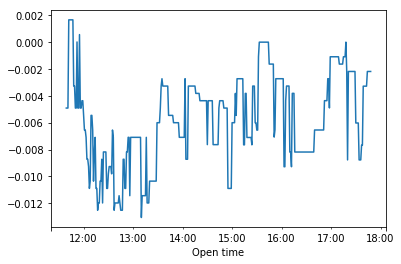

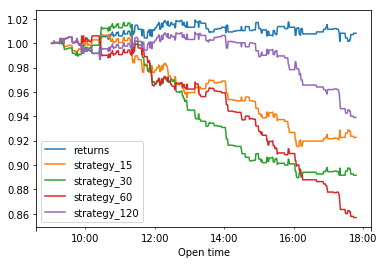

1548054021555 1548092906447
CVCBTC 2019-01-21 00:59:01.170000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


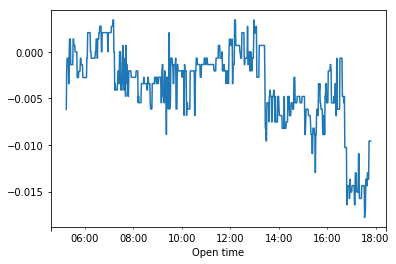

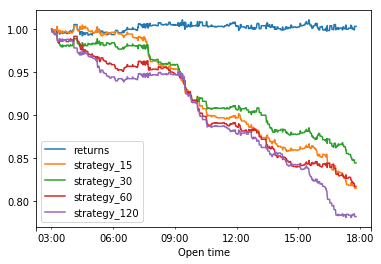

1548032341169 1548092906447
MODBTC 2019-01-21 05:58:29.146000 2019-01-21 12:48:26.447000


/home/me/bw-env/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


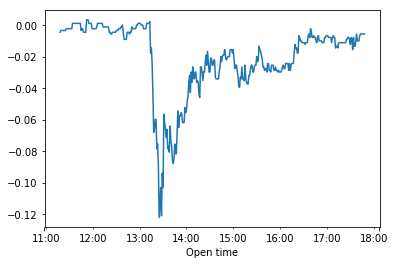

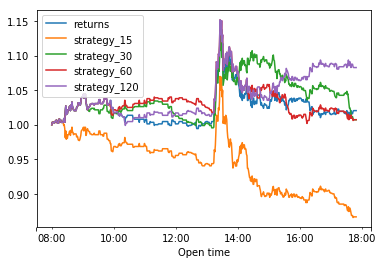

1548050309146 1548092906447


In [71]:

def bollinger_strat(df,window,std):
    df = df.copy()
    rolling_mean = df['Close'].rolling(window).mean()
    rolling_std = df['Close'].rolling(window).std()
    
    df['Bollinger High'] = rolling_mean + (rolling_std * std)
    df['Bollinger Low'] = rolling_mean - (rolling_std * std)
    
    df['Short'] = None
    df['Long'] = None
    df['Position'] = None
    
    for row in range(len(df)):
    
        if (df['Close'].iloc[row] > df['Bollinger High'].iloc[row]) and (df['Close'].iloc[row-1] < df['Bollinger High'].iloc[row-1]):
            df['Position'].iloc[row] = -1
        
        if (df['Close'].iloc[row] < df['Bollinger Low'].iloc[row]) and (df['Close'].iloc[row-1] > df['Bollinger Low'].iloc[row-1]):
            df['Position'].iloc[row] = 1
            
    df['Position'].fillna(method='ffill',inplace=True)
    
    df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Strategy Return'] = df['Market Return'] * df['Position']
    
    df['Strategy Return'].cumsum().plot()
    plt.show()
    return df['Strategy Return'].cumsum().iloc[-1]

def mean_rev(df):
    #create column to hold our 90 day rolling standard deviation
    df['Stdev'] = df['Close'].rolling(window=90).std()

    #create a column to hold our 20 day moving average
    df['Moving Average'] = df['Close'].rolling(window=20).mean()

    #create a column which holds a TRUE value if the gap down from previous day's low to next 
    #day's open is larger than the 90 day rolling standard deviation
    df['Criteria1'] = (df['Open'] - df['Low'].rolling(window=20).mean()) < -df['Stdev'] 

    #create a column which holds a TRUE value if the opening price of the stock is above the 20 day moving average 
    df['Criteria2'] = df['Open'] > df['Moving Average']

    #create a column that holds a TRUE value if both above criteria are also TRUE
    df['BUY'] = df['Criteria1'] & df['Criteria2']

    #calculate daily % return series for stock
    df['Pct Change'] = (df['Close'] - df['Open']) / df['Open']

    #create a strategy return series by using the daily stock returns where the trade criteria above are met
    df['Strategy Return'] = df['Pct Change'][df['BUY'] == True]
    df['Strategy Return'].cumsum().plot()
    plt.show()
    return df['Strategy Return'].cumsum().iloc[-1]

def mom_strat(df):
    df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
    cols = []
    for momentum in [15, 30, 60, 120]:
        col = 'position_%s' % momentum
        df[col] = np.sign(df['returns'].rolling(momentum).mean())
        cols.append(col)
    strats = ['returns']  # 19

    for col in cols:  # 20
        strat = 'strategy_%s' % col.split('_')[1]  # 21
        df[strat] = df[col].shift(1) * df['returns']  # 22
        strats.append(strat)  # 23

    df[strats].dropna().cumsum().apply(np.exp).plot()  # 24
    plt.show()
    return df[strats].dropna().cumsum().iloc[-1]
        
today_hist = {}
now = current_milli_time()
windows = [50,150,250,500]
stds = [1,2]
rets = [] 
for t in today.index:
    st,end = int(unix_time_millis(today.loc[t]['Entry'])),now
    t_hist = get_data(t,st,end,"1m")
    print(t,today.loc[t]['Entry'],to_dt(now))
    ret = bollinger_strat(t_hist.copy(),250,1)
    ret2 = mom_strat(t_hist.copy())
    
    
    """ 
    #And iterate through them both, running the strategy function each time
    for window in windows:
        for std in stds:
            bollinger_strat(t_hist.copy(),window,std)
            print(window,std)
            plt.show()
    """
    print(st,end)
    today_hist[t] = t_hist
    